# **Dataset prepare**

In [ ]:
import csv
import random

def generate_firefighter_data():
    # Total time is always 60 seconds
    total_time = 60

    # Time to extinguish fire (up to 60 seconds)
    time_to_extinguish = random.randint(30, 70)  # Allow for possibility of not extinguishing in time

    # Calculate other metrics based on whether fire was extinguished in time
    success = time_to_extinguish <= total_time

    if success:
        assessment_time = random.randint(5, 15)
        action_time = time_to_extinguish - assessment_time
    else:
        assessment_time = random.randint(5, 15)
        action_time = total_time - assessment_time

    # High temperature time (a portion of action time)
    high_temp_time = random.randint(5, action_time)

    # Calculate extinguishing agent used based on action time
    # For a 10 kg extinguisher, assume it can discharge 9-10 liters in about 20-25 seconds
    max_discharge_time = random.uniform(20, 25)
    discharge_rate = random.uniform(9, 10) / max_discharge_time  # liters per second
    extinguisher_used = min(round(discharge_rate * action_time, 1), 10)  # Cap at 10 liters

    return [
        time_to_extinguish if success else total_time,  # Time taken (capped at 60 if not successful)
        extinguisher_used,  # Amount of extinguishing agent used (liters)
        random.randint(0, 10),  # Number of incorrect actions (0 to 10)
        round(random.uniform(0.3, 1.0), 2),  # Accuracy of aiming (0.3 to 1.0)
        round(random.uniform(1, 5), 1),  # Distance from fire (meters)
        assessment_time,  # Assessment time (seconds)
        round(random.uniform(0.3, 1.5), 1),  # Movement speed (m/s)
        high_temp_time,  # Time in high-temp zones (seconds)
        1 if success else 0  # Outcome (1 for success, 0 for failure)
    ]

# Generate the dataset
dataset = [generate_firefighter_data() for _ in range(5000)]

# Write to CSV file
with open('firefighter_training_data_10kg_extinguisher_1min.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow([
        "Time_Taken", "Extinguisher_Used", "Incorrect_Actions", "Aiming_Accuracy",
        "Distance_From_Fire", "Assessment_Time", "Movement_Speed",
        "High_Temp_Time", "Outcome"
    ])
    writer.writerows(dataset)

print("Dataset generated and saved to 'firefighter_training_data_10kg_extinguisher_1min.csv'")

Dataset generated and saved to 'firefighter_training_data_10kg_extinguisher_1min.csv'


# **Import Libraries**

In [ ]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import StandardScaler

import warnings

# Suppress warnings
warnings.filterwarnings("ignore")

# **Load the Dataset**

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/CSE400/firefighter_training_data_10kg_extinguisher_1min.csv")

# **Examine the Dataset**

In [ ]:
data.shape

(5000, 9)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Time_Taken          5000 non-null   int64  
 1   Extinguisher_Used   5000 non-null   float64
 2   Incorrect_Actions   5000 non-null   int64  
 3   Aiming_Accuracy     5000 non-null   float64
 4   Distance_From_Fire  5000 non-null   float64
 5   Assessment_Time     5000 non-null   int64  
 6   Movement_Speed      5000 non-null   float64
 7   High_Temp_Time      5000 non-null   int64  
 8   Outcome             5000 non-null   int64  
dtypes: float64(4), int64(5)
memory usage: 351.7 KB


In [ ]:
data.head()

,Time_Taken,Extinguisher_Used,Incorrect_Actions,Aiming_Accuracy,Distance_From_Fire,Assessment_Time,Movement_Speed,High_Temp_Time,Outcome
0,60,10.0,2,0.48,4.6,6,0.5,25,0
1,45,10.0,9,0.61,1.1,8,0.6,5,1
2,60,10.0,1,0.34,4.1,7,1.5,52,1
3,34,7.7,10,0.38,3.0,15,0.9,15,1
4,42,10.0,4,0.84,2.3,12,1.0,25,1


In [ ]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Time_Taken,5000.0,48.677400,10.121058,30.0,40.00,50.00,60.0000,60.0
Extinguisher_Used,5000.0,9.842340,0.559299,5.9,10.00,10.00,10.0000,10.0
Incorrect_Actions,5000.0,5.007800,3.144474,0.0,2.00,5.00,8.0000,10.0
Aiming_Accuracy,5000.0,0.649128,0.204794,0.3,0.47,0.65,0.8225,1.0
Distance_From_Fire,5000.0,2.970580,1.159956,1.0,2.00,2.90,4.0000,5.0
Assessment_Time,5000.0,9.983000,3.164919,5.0,7.00,10.00,13.0000,15.0
Movement_Speed,5000.0,0.899940,0.348669,0.3,0.60,0.90,1.2000,1.5
High_Temp_Time,5000.0,21.834000,11.630421,5.0,12.00,20.00,30.0000,55.0
Outcome,5000.0,0.751200,0.432361,0.0,1.00,1.00,1.0000,1.0


array([[<Axes: title={'center': 'Time_Taken'}>,
        <Axes: title={'center': 'Extinguisher_Used'}>,
        <Axes: title={'center': 'Incorrect_Actions'}>],
       [<Axes: title={'center': 'Aiming_Accuracy'}>,
        <Axes: title={'center': 'Distance_From_Fire'}>,
        <Axes: title={'center': 'Assessment_Time'}>],
       [<Axes: title={'center': 'Movement_Speed'}>,
        <Axes: title={'center': 'High_Temp_Time'}>,
        <Axes: title={'center': 'Outcome'}>]], dtype=object)

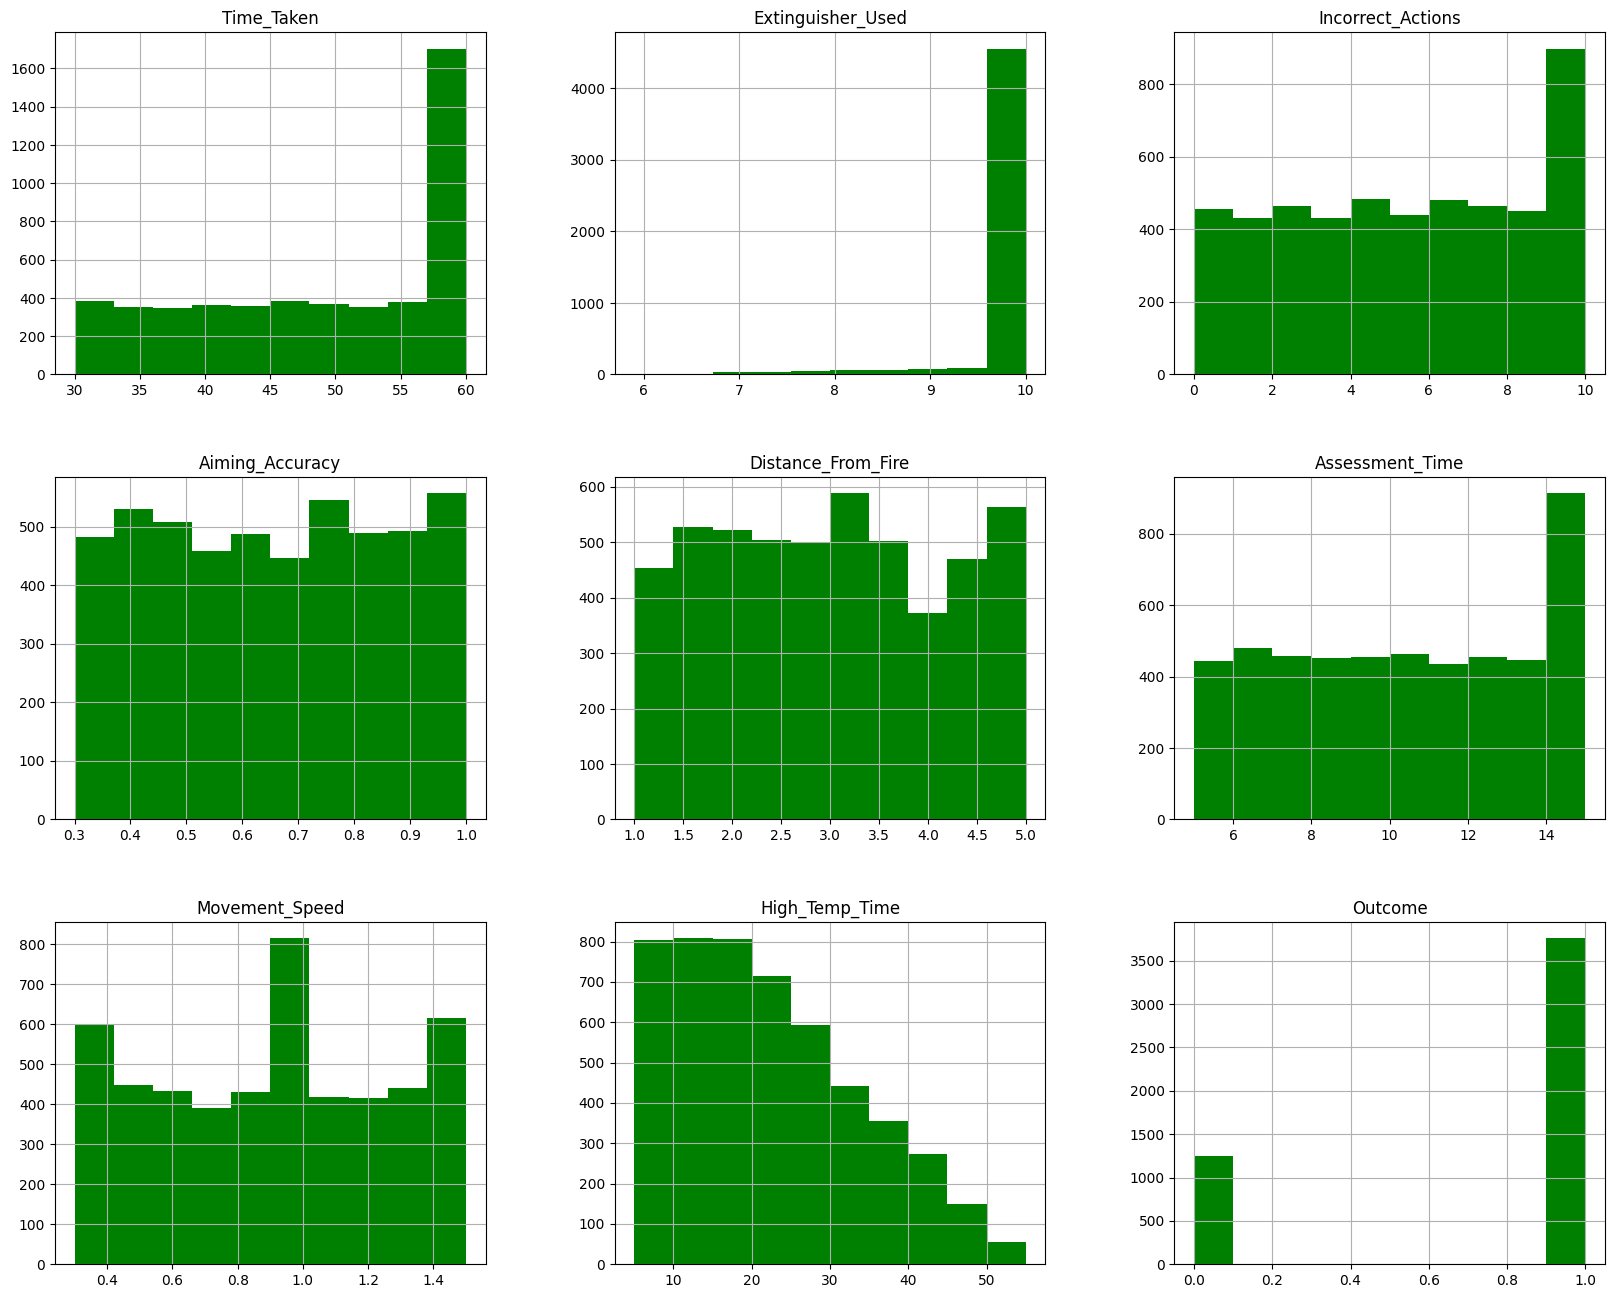

In [ ]:
data.hist(figsize=(20, 16), color='green')

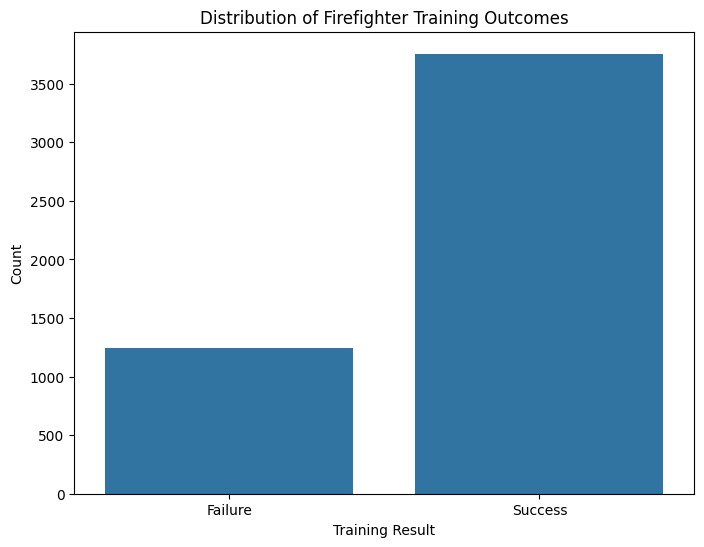

In [ ]:
new_data = pd.read_csv("/content/drive/MyDrive/CSE400/firefighter_training_data_10kg_extinguisher_1min.csv")
class_label_mapping = {0: "Failure", 1: "Success"}
new_data["outcome_class"] = new_data["Outcome"].map(class_label_mapping)

plt.figure(figsize=(8, 6))
sns.countplot(
    x="outcome_class", data=new_data, order=["Failure", "Success"]
)
plt.title("Distribution of Firefighter Training Outcomes")
plt.xlabel("Training Result")
plt.ylabel("Count")

plt.show()

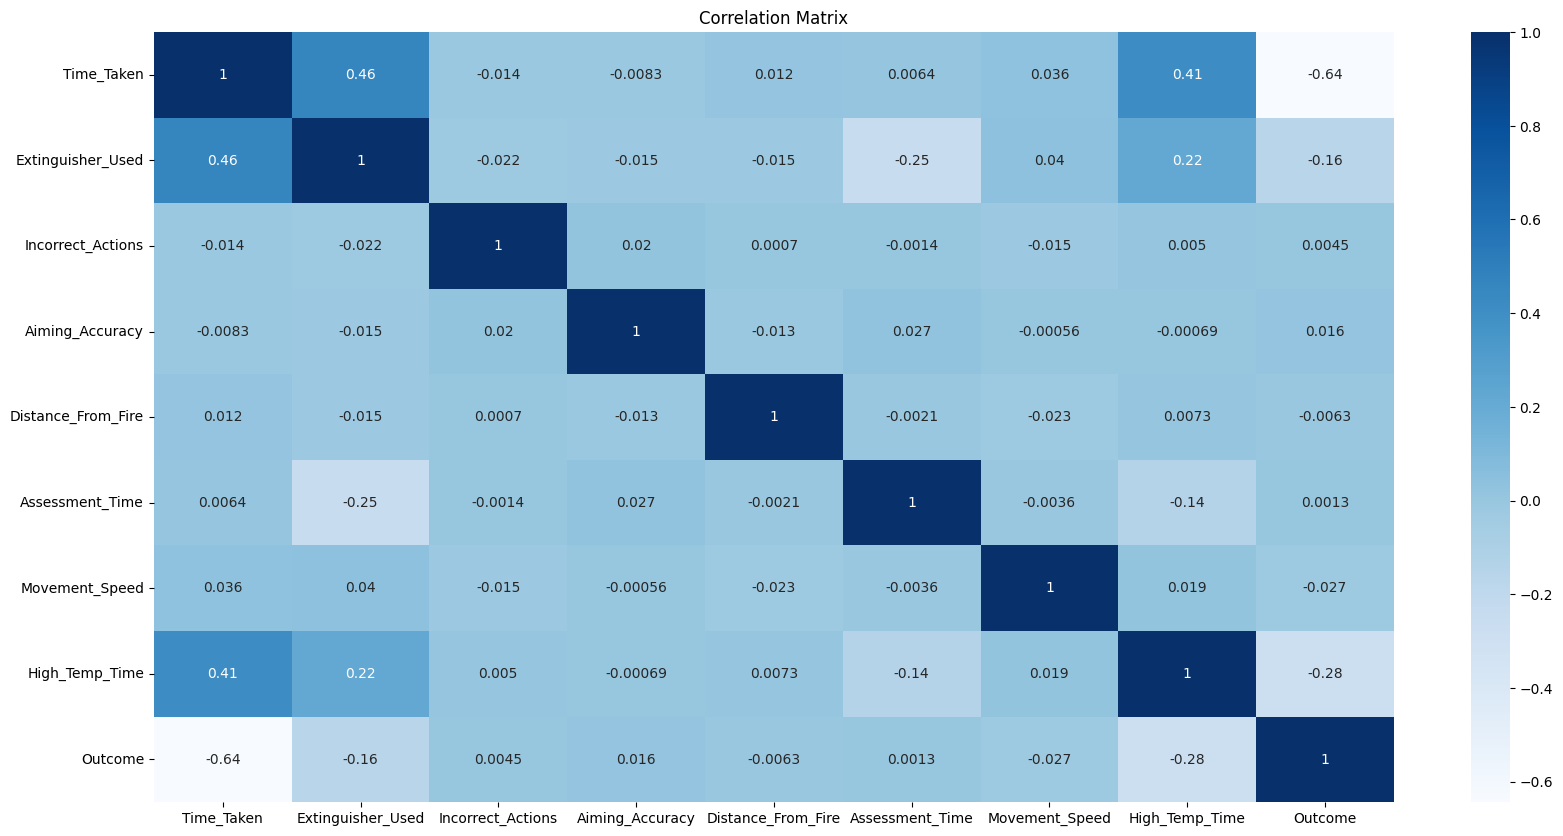

In [ ]:
corr_matrix = data.corr()

plt.figure(figsize=(20, 10))
sns.heatmap(corr_matrix, annot=True, cmap="Blues")
plt.title("Correlation Matrix")
plt.show()

# **Check for Null Values**

In [ ]:
data.isnull().sum()

Time_Taken            0
Extinguisher_Used     0
Incorrect_Actions     0
Aiming_Accuracy       0
Distance_From_Fire    0
Assessment_Time       0
Movement_Speed        0
High_Temp_Time        0
Outcome               0
dtype: int64

In [ ]:
data["Outcome"].value_counts()

Outcome
1    3756
0    1244
Name: count, dtype: int64

# **Setting Target**

In [ ]:
X_normal = data.drop("Outcome", axis=1)
Y = data["Outcome"]

# **Scaling the Data**

In [ ]:
Scaler = StandardScaler()
X = Scaler.fit_transform(X_normal)
X = pd.DataFrame(X, columns=X_normal.columns)
X.head()

,Time_Taken,Extinguisher_Used,Incorrect_Actions,Aiming_Accuracy,Distance_From_Fire,Assessment_Time,Movement_Speed,High_Temp_Time
0,1.118829,0.281917,-0.956631,-0.825929,1.404866,-1.258610,-1.147161,0.272244
1,-0.363378,0.281917,1.269719,-0.191080,-1.612792,-0.626619,-0.860328,-1.447556
2,1.118829,0.281917,-1.274681,-1.509612,0.973772,-0.942614,1.721172,2.593975
3,-1.450329,-3.830782,1.587769,-1.314274,0.025366,1.585349,0.000172,-0.587656
4,-0.659819,0.281917,-0.320531,0.932114,-0.578166,0.637363,0.287005,0.272244


In [ ]:
Y.value_counts()

Outcome
1    3756
0    1244
Name: count, dtype: int64


# **Train-Test Split**

In [ ]:
# 80% of the data will be used for training
# 20% of the data will be used for testing

X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)

# **Model Training and Evaluation**

## 1. Logistic Regression
Logistic Regression is a statistical model and a classification algorithm that models the probability of a binary outcome (1/0, True/False, Yes/No) based on one or more predictor variables. It uses the logistic function to model the probability and makes predictions by applying a threshold to the predicted probabilities.

Best Hyperparameters for Logistic Regression: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
Best Accuracy of Logistic Regression model: 97.90%

Classification Report - Logistic Regression:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96       250
           1       1.00      0.97      0.99       750

    accuracy                           0.98      1000
   macro avg       0.96      0.99      0.97      1000
weighted avg       0.98      0.98      0.98      1000



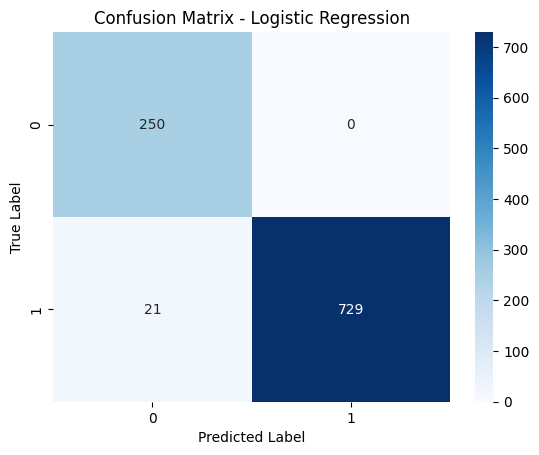

In [ ]:
# Define the parameter grid for Logistic Regression
logreg_param_grid = {
    "penalty": ["l1", "l2"],
    "C": np.logspace(-3, 3, 7),
    "solver": ["liblinear"],
}

# Create a Logistic Regression model
logreg_model = LogisticRegression(random_state=42)

# Perform grid search with cross-validation
logreg_grid_search = GridSearchCV(
    logreg_model, logreg_param_grid, cv=5, scoring="accuracy"
)
logreg_grid_search.fit(X_train, Y_train)

# Get the best parameters
best_logreg_params = logreg_grid_search.best_params_
print("Best Hyperparameters for Logistic Regression:", best_logreg_params)

# Train a Logistic Regression model with the best parameters
best_logreg_model = LogisticRegression(random_state=42, **best_logreg_params)
best_logreg_model.fit(X_train, Y_train)

# Make predictions on the test set
logreg_predict = best_logreg_model.predict(X_test)

# Calculate accuracy on the test set
best_logreg_acc = accuracy_score(Y_test, logreg_predict)
print(
    "Best Accuracy of Logistic Regression model:",
    "{:.2f}%".format(best_logreg_acc * 100),
)

# Display classification report
print("\nClassification Report - Logistic Regression:")
lr_cr = classification_report(Y_test, logreg_predict)
print(lr_cr)

# Display confusion matrix
logreg_cm = confusion_matrix(Y_test, logreg_predict)

# Plot the confusion matrix
sns.heatmap(logreg_cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

## 2. Decision Tree
A Decision Tree is a supervised machine learning algorithm that recursively splits the dataset into subsets based on the most significant attribute, creating a tree-like structure of decisions to predict the target variable.

Best Hyperparameters: {'criterion': 'gini', 'max_depth': 1, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2}
Accuracy of Decision Tree with Best Parameters: 97.90%

Classification Report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96       250
           1       1.00      0.97      0.99       750

    accuracy                           0.98      1000
   macro avg       0.96      0.99      0.97      1000
weighted avg       0.98      0.98      0.98      1000



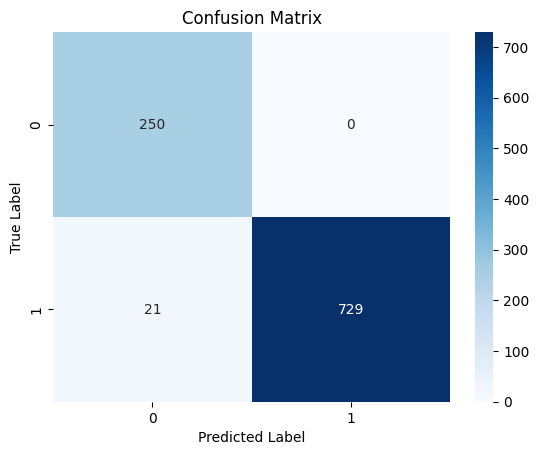

In [ ]:
# Define the parameter grid
param_grid = {
    "criterion": ["gini", "entropy"],
    "max_depth": np.arange(1, 21),
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2", None],
}

# Create a Decision Tree model
DT = DecisionTreeClassifier(random_state=0)

# Perform grid search with cross-validation
grid_search = GridSearchCV(DT, param_grid, cv=5, scoring="accuracy")
grid_search.fit(X_train, Y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Train a Decision Tree with the best parameters
best_DT = DecisionTreeClassifier(random_state=0, **best_params)
best_DT.fit(X_train, Y_train)

# Make predictions on the test set
DT_predict = best_DT.predict(X_test)

# Calculate accuracy on the test set
max_dt_acc = accuracy_score(Y_test, DT_predict)
print(
    "Accuracy of Decision Tree with Best Parameters:",
    "{:.2f}%".format(max_dt_acc * 100),
)

# Display classification report
print("\nClassification Report:")
dt_cr = classification_report(Y_test, DT_predict)
print(dt_cr)

# Display confusion matrix
DT_cm = confusion_matrix(Y_test, DT_predict)

# Plot the confusion matrix
sns.heatmap(DT_cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# **3. Random Forest**
Random Forest is an ensemble learning algorithm for classification, regression, and other tasks that constructs a multitude of decision trees during training and outputs the mode (classification) or mean (regression) prediction of the individual trees.

Best Hyperparameters for Random Forest: {'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 20, 'random_state': 12}
Best Accuracy of Random Forest: 97.90%

Classification Report - Random Forest:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96       250
           1       1.00      0.97      0.99       750

    accuracy                           0.98      1000
   macro avg       0.96      0.99      0.97      1000
weighted avg       0.98      0.98      0.98      1000



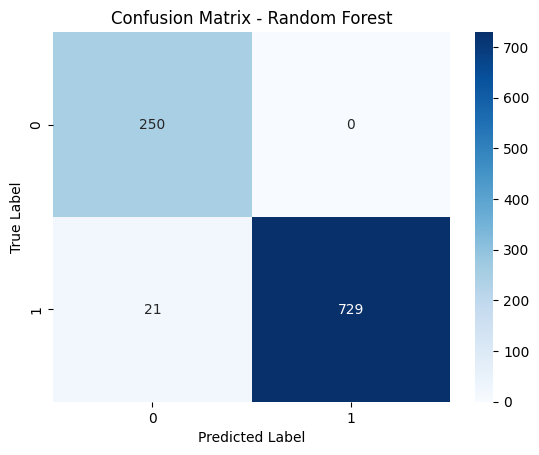

In [ ]:
# Define the parameter grid for Random Forest
rf_param_grid = {
    "n_estimators": [10, 20, 50, 100],
    "max_depth": [None, 5, 10, 15],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["auto", "sqrt", "log2"],
    "random_state": [12],
}

# Create a Random Forest model
RF = RandomForestClassifier()

# Perform grid search with cross-validation
rf_grid_search = GridSearchCV(RF, rf_param_grid, cv=5, scoring="accuracy")
rf_grid_search.fit(X_train, Y_train)

# Get the best parameters
best_rf_params = rf_grid_search.best_params_
print("Best Hyperparameters for Random Forest:", best_rf_params)

# Train a Random Forest model with the best parameters
best_RF_model = RandomForestClassifier(**best_rf_params)
best_RF_model.fit(X_train, Y_train)

# Make predictions on the test set
RF_predict = best_RF_model.predict(X_test)

# Calculate accuracy on the test set
best_RF_acc = accuracy_score(Y_test, RF_predict)
print("Best Accuracy of Random Forest:", "{:.2f}%".format(best_RF_acc * 100))

# Display classification report
print("\nClassification Report - Random Forest:")
rf_cr = classification_report(Y_test, RF_predict)
print(rf_cr)

# Display confusion matrix
RF_cm = confusion_matrix(Y_test, RF_predict)

# Plot the confusion matrix
sns.heatmap(RF_cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# **4. SVM**
Support Vector Machine (SVM) is a supervised machine learning algorithm for classification and regression that finds the hyperplane in an N-dimensional space that best separates the data points of different classes.

Best Hyperparameters for Support Vector Classifier: {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
Best Accuracy of Support Vector Classifier: 97.90%

Classification Report - Support Vector Classifier:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96       250
           1       1.00      0.97      0.99       750

    accuracy                           0.98      1000
   macro avg       0.96      0.99      0.97      1000
weighted avg       0.98      0.98      0.98      1000



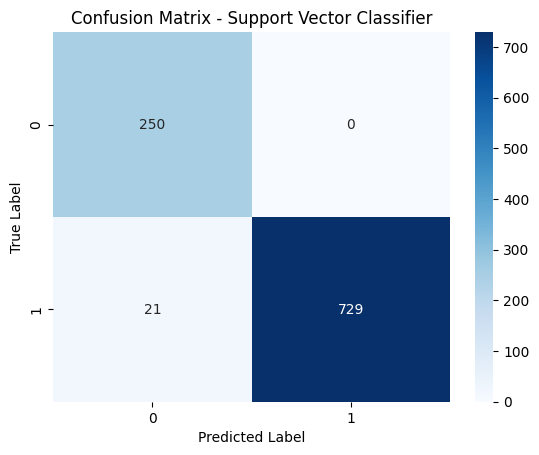

In [ ]:
# Define the parameter grid for Support Vector Classifier
svm_param_grid = {
    "C": [0.1, 1, 10, 100],
    "gamma": ["scale", "auto", 0.001, 0.01, 0.1, 1, 10],
    "kernel": ["rbf"],
}

# Create a Support Vector Classifier model
SVM = SVC()

# Perform grid search with cross-validation
svm_grid_search = GridSearchCV(SVM, svm_param_grid, cv=5, scoring="accuracy")
svm_grid_search.fit(X_train, Y_train)

# Get the best parameters
best_svm_params = svm_grid_search.best_params_
print("Best Hyperparameters for Support Vector Classifier:", best_svm_params)

# Train a Support Vector Classifier model with the best parameters
best_SVM_model = SVC(**best_svm_params)
best_SVM_model.fit(X_train, Y_train)

# Make predictions on the test set
SVM_predict = best_SVM_model.predict(X_test)

# Calculate accuracy on the test set
best_SVM_acc = accuracy_score(Y_test, SVM_predict)
print(
    "Best Accuracy of Support Vector Classifier:", "{:.2f}%".format(best_SVM_acc * 100)
)

# Display classification report
print("\nClassification Report - Support Vector Classifier:")
svm_cr = classification_report(Y_test, SVM_predict)
print(svm_cr)

# Display confusion matrix
SVM_cm = confusion_matrix(Y_test, SVM_predict)

# Plot the confusion matrix
sns.heatmap(SVM_cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Support Vector Classifier")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# **5. XGBoost**
XGBoost, a gradient boosting framework, excels in structured data problems and is known for its performance and speed.

Best Hyperparameters for XGBoost: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'random_state': 42}
Best Accuracy of XGBoost model: 97.90%

Classification Report - XGBoost:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96       250
           1       1.00      0.97      0.99       750

    accuracy                           0.98      1000
   macro avg       0.96      0.99      0.97      1000
weighted avg       0.98      0.98      0.98      1000



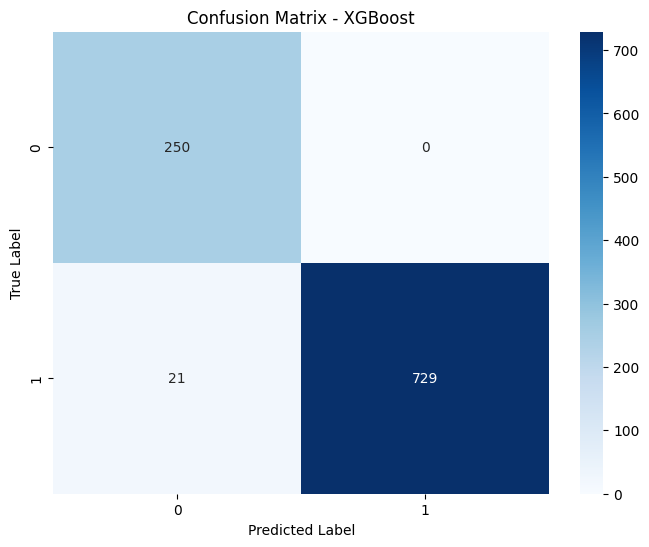

In [ ]:
from xgboost import XGBClassifier

# Define the parameter grid for XGBoost
xgb_param_grid = {
    "n_estimators": [100, 200, 300],
    "learning_rate": [0.01, 0.1, 0.3],
    "max_depth": [3, 5, 7],
    "random_state": [42]
}

# Create an XGBoost model
xgb_classifier = XGBClassifier()

# Perform grid search with cross-validation
xgb_grid_search = GridSearchCV(
    xgb_classifier, xgb_param_grid, cv=5, scoring="accuracy"
)
xgb_grid_search.fit(X_train, Y_train)

# Get the best parameters
best_xgb_params = xgb_grid_search.best_params_
print("Best Hyperparameters for XGBoost:", best_xgb_params)

# Train an XGBoost model with the best parameters
best_xgb_model = XGBClassifier(**best_xgb_params)
best_xgb_model.fit(X_train, Y_train)

# Make predictions on the test set
xgb_predict = best_xgb_model.predict(X_test)

# Calculate accuracy on the test set
xgb_acc_score = accuracy_score(Y_test, xgb_predict)
print("Best Accuracy of XGBoost model:", "{:.2f}%".format(xgb_acc_score * 100))

# Display classification report
print("\nClassification Report - XGBoost:")
xgb_cr = classification_report(Y_test, xgb_predict)
print(xgb_cr)

# Display confusion matrix
xgb_cm = confusion_matrix(Y_test, xgb_predict)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(xgb_cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - XGBoost")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# **Neural Network Models**

# **FNN**

Epoch 1/100
100/100 [==============================] - 2s 8ms/step - loss: 0.3142 - accuracy: 0.8587 - val_loss: 0.2132 - val_accuracy: 0.9038
Epoch 2/100
100/100 [==============================] - 1s 9ms/step - loss: 0.2017 - accuracy: 0.9128 - val_loss: 0.1700 - val_accuracy: 0.9413
Epoch 3/100
100/100 [==============================] - 0s 4ms/step - loss: 0.1735 - accuracy: 0.9316 - val_loss: 0.1579 - val_accuracy: 0.9438
Epoch 4/100
100/100 [==============================] - 0s 4ms/step - loss: 0.1575 - accuracy: 0.9366 - val_loss: 0.1540 - val_accuracy: 0.9413
Epoch 5/100
100/100 [==============================] - 0s 4ms/step - loss: 0.1413 - accuracy: 0.9459 - val_loss: 0.1404 - val_accuracy: 0.9438
Epoch 6/100
100/100 [==============================] - 0s 4ms/step - loss: 0.1342 - accuracy: 0.9472 - val_loss: 0.1301 - val_accuracy: 0.9563
Epoch 7/100
100/100 [==============================] - 0s 4ms/step - loss: 0.1261 - accuracy: 0.9484 - val_loss: 0.1298 - val_accuracy: 0.9525

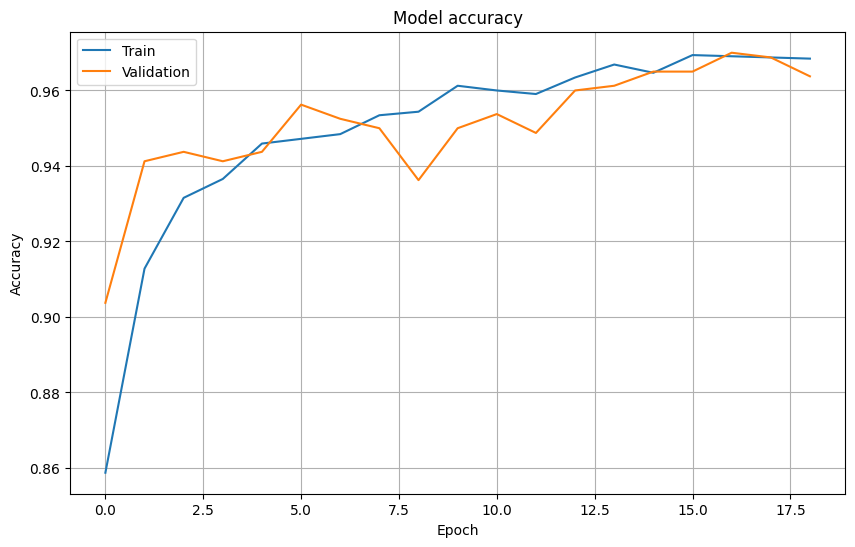

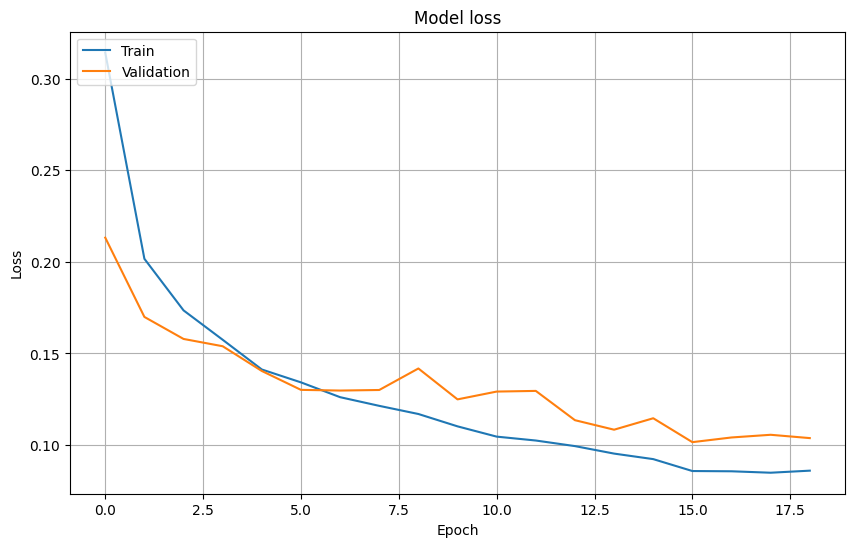

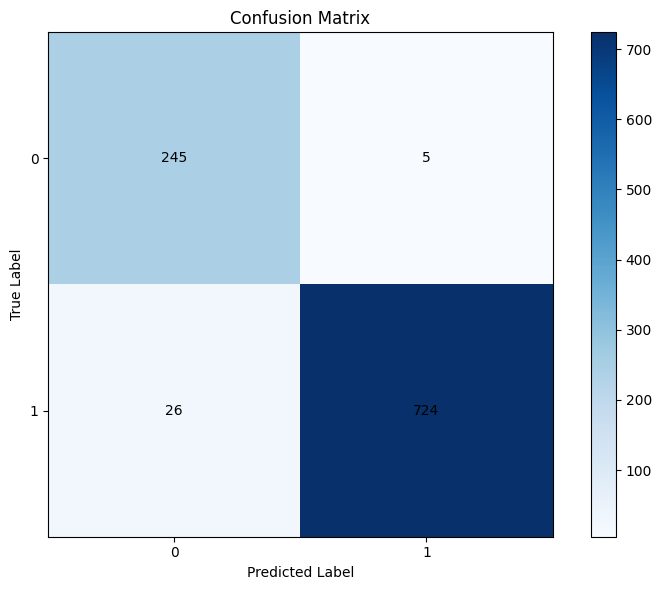

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

# Assuming X and Y are your features and labels
# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Function to build a Feedforward Neural Network
def build_fnn(input_shape, num_classes):
    model = models.Sequential([
        layers.Dense(128, activation='relu', input_shape=(input_shape,)),
        layers.Dense(64, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

# Build and compile the model
input_shape = X_train.shape[1]
num_classes = len(np.unique(Y_train))
fnn_model = build_fnn(input_shape, num_classes)
fnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model with metrics logged
history = fnn_model.fit(X_train, Y_train, epochs=100, validation_split=0.2,
                        callbacks=[callbacks.EarlyStopping(monitor='val_loss', patience=3)],
                        verbose=1)

# Evaluate the model
Y_pred_fnn = np.argmax(fnn_model.predict(X_test), axis=1)
print("Classification Report for FNN:")
print(classification_report(Y_test, Y_pred_fnn))
print("Confusion Matrix for FNN:")
print(confusion_matrix(Y_test, Y_pred_fnn))

# Plot training & validation accuracy values
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.grid(True)
plt.savefig('accuracy_loss_plots.png')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.grid(True)
plt.savefig('accuracy_loss_plots.png')
plt.show()

# Generate confusion matrix plot
plt.figure(figsize=(8, 6))
cm = confusion_matrix(Y_test, Y_pred_fnn)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, range(num_classes))
plt.yticks(tick_marks, range(num_classes))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()

# Add numerical values in the plot
width, height = cm.shape
for x in range(width):
    for y in range(height):
        plt.annotate(str(cm[x][y]), xy=(y, x), horizontalalignment='center', verticalalignment='center')

# Save the plot as an image
plt.savefig('confusion_matrix.png')
plt.show()


# **wide deep neural network**

Epoch 1/100
100/100 [==============================] - 2s 5ms/step - loss: 0.6650 - accuracy: 0.7266 - val_loss: 0.2373 - val_accuracy: 0.8975
Epoch 2/100
100/100 [==============================] - 0s 4ms/step - loss: 0.2121 - accuracy: 0.9059 - val_loss: 0.1940 - val_accuracy: 0.9112
Epoch 3/100
100/100 [==============================] - 0s 3ms/step - loss: 0.1810 - accuracy: 0.9203 - val_loss: 0.2079 - val_accuracy: 0.8850
Epoch 4/100
100/100 [==============================] - 0s 4ms/step - loss: 0.1644 - accuracy: 0.9328 - val_loss: 0.1531 - val_accuracy: 0.9463
Epoch 5/100
100/100 [==============================] - 0s 4ms/step - loss: 0.1477 - accuracy: 0.9444 - val_loss: 0.1445 - val_accuracy: 0.9475
Epoch 6/100
100/100 [==============================] - 0s 4ms/step - loss: 0.1383 - accuracy: 0.9463 - val_loss: 0.1466 - val_accuracy: 0.9450
Epoch 7/100
100/100 [==============================] - 0s 4ms/step - loss: 0.1310 - accuracy: 0.9503 - val_loss: 0.1336 - val_accuracy: 0.9500

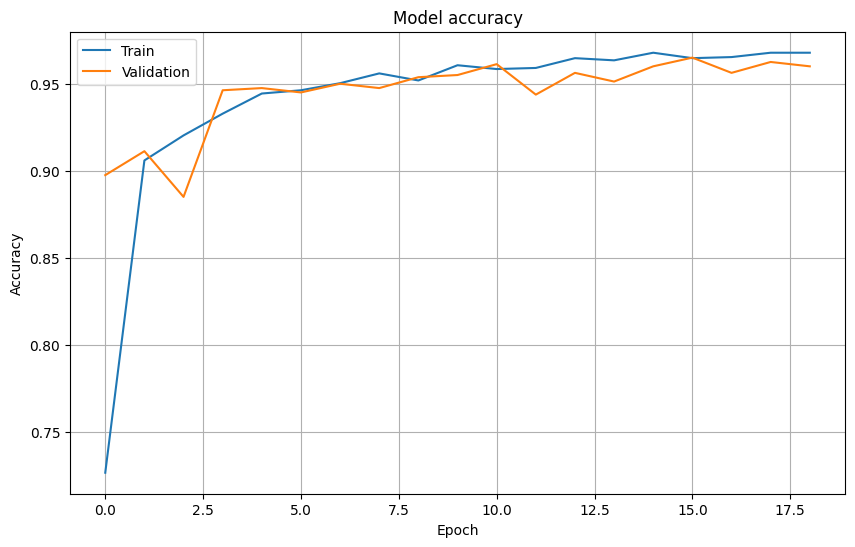

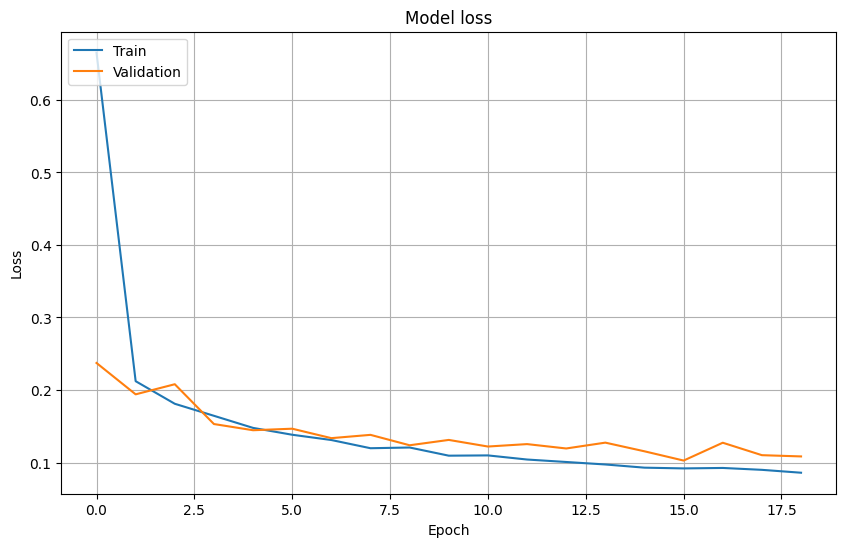

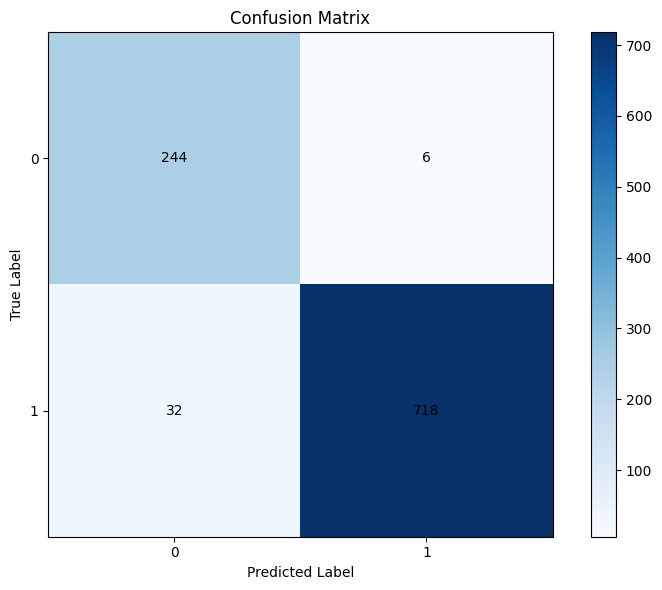

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

# Assuming X and Y are your features and labels
# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Function to build a Wide and Deep Learning Network
def build_wide_and_deep(input_shape, num_classes):
    # Wide model
    wide_input = layers.Input(shape=(input_shape,), name='wide_input')
    wide_output = layers.Dense(num_classes, activation='linear', name='wide_output')(wide_input)

    # Deep model
    deep_input = layers.Input(shape=(input_shape,), name='deep_input')
    deep = layers.Dense(128, activation='relu')(deep_input)
    deep = layers.Dense(64, activation='relu')(deep)
    deep_output = layers.Dense(num_classes, activation='linear', name='deep_output')(deep)

    # Combine wide and deep
    combined = layers.Add()([wide_output, deep_output])
    output = layers.Activation('softmax')(combined)

    model = models.Model(inputs=[wide_input, deep_input], outputs=output)
    return model

# Build and compile the model
input_shape = X_train.shape[1]
num_classes = len(np.unique(Y_train))
wide_and_deep_model = build_wide_and_deep(input_shape, num_classes)
wide_and_deep_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model with metrics logged
history = wide_and_deep_model.fit([X_train, X_train], Y_train, epochs=100, validation_split=0.2,
                                  callbacks=[callbacks.EarlyStopping(monitor='val_loss', patience=3)],
                                  verbose=1)

# Evaluate the model
Y_pred_wide_deep = np.argmax(wide_and_deep_model.predict([X_test, X_test]), axis=1)
print("Classification Report for Wide and Deep Model:")
print(classification_report(Y_test, Y_pred_wide_deep))
print("Confusion Matrix for Wide and Deep Model:")
print(confusion_matrix(Y_test, Y_pred_wide_deep))

# Plot training & validation accuracy values
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.grid(True)
plt.savefig('accuracy_plot_wide_deep.png')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.grid(True)
plt.savefig('loss_plot_wide_deep.png')
plt.show()

# Generate confusion matrix plot
plt.figure(figsize=(8, 6))
cm = confusion_matrix(Y_test, Y_pred_wide_deep)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, range(num_classes))
plt.yticks(tick_marks, range(num_classes))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()

# Add numerical values in the plot
width, height = cm.shape
for x in range(width):
    for y in range(height):
        plt.annotate(str(cm[x][y]), xy=(y, x), horizontalalignment='center', verticalalignment='center')

# Save the plot as an image
plt.savefig('confusion_matrix_wide_deep.png')
plt.show()